# Power manifold

In [88]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import torch
import logging
from matplotlib import pyplot as plt, cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")
from experiments.simulators import PowerManifoldSimulator
from experiments.utils.models import create_vector_transform
from manifold_flow.flows import ManifoldFlow
import plot_settings as ps

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [89]:
ps.setup()

## Set up simulator

In [90]:
sim = PowerManifoldSimulator(
    draw_constants=False,
    filename="../data/samples/power/manifold.npz"
)


## Load flows

In [91]:
def load_model(filename):
    outer_transform = create_vector_transform(
        3,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=0.,
        tail_bound=6.,
        num_bins=10,
    )
    inner_transform = create_vector_transform(
        2,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=sim.parameter_dim(),
        dropout_probability=0.,
        tail_bound=6.,
        num_bins=10,
    )

    model = ManifoldFlow(
        data_dim=3,
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
    )
    
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [92]:
mlfa = load_model("mf_2_power_alternate_march_run2")
pie = load_model("pie_2_power_march_run1")
mlfot = load_model("gamf_2_power_march_run2")


16:03 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
16:03 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB
16:03 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
16:03 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB
16:03 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
16:03 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB


## Get data

In [93]:
def make_grid(boundary, res):
    grid_each = np.linspace(-boundary, boundary, res)
    x, y = np.meshgrid(grid_each, grid_each)
    xy = np.vstack((x.flatten(), y.flatten())).T
    return xy

In [94]:
thetas = [-1., 0., 1.]
boundary = 3. # 5.
res = 25  # 80

z_grid = make_grid(boundary, res)
f_grid = sim._fz(z_grid).flatten()
x_grid = sim._transform_z_to_x(z_grid)

In [95]:
true_logp_grid = np.array(
    [sim._log_density_z(z_grid, parameters=theta*np.ones((res**2,1))).flatten() for theta in thetas]
)


In [96]:
def eval_model(model, algo, batchsize=400, thetas=thetas):
    print("Let's go!")
    n_batches = (res**2 - 1) // batchsize + 1

    model_x_grid = []
    model_logp_grid = []

    for i_theta, theta in enumerate(thetas):
        print("Theta {} / {}".format(i_theta + 1, len(thetas)))
        for i in range(n_batches):
            print("Batch {} / {}".format(i + 1, n_batches))
            x_batch = x_grid[i*batchsize:(i+1)*batchsize]
            n_batch = len(x_batch)

            theta_ = torch.tensor(theta*np.ones((n_batch,1)), dtype=torch.float)
            x_ = torch.tensor(x_batch, dtype=torch.float)

            x_reco_, logp_, u_ = model(x_, mode=algo, context=theta_)
            if algo=="pie":
                _, logp_, _ = model(x_reco_, mode=algo, context=theta_)

            model_x_grid.append(x_reco_.detach().numpy().flatten())
            model_logp_grid.append(logp_.detach().numpy().flatten())

    model_logp_grid = np.hstack(model_logp_grid).reshape((len(thetas), -1))
    model_x_grid = np.hstack(model_x_grid).reshape((len(thetas), -1, 3))

    return model_x_grid, model_logp_grid


In [97]:
mlfa_x_grid, mlfa_logp_grid = eval_model(mlfa, "mf")
mlfot_x_grid, mlfot_logp_grid = eval_model(mlfot, "mf", thetas=[0.])

Let's go!
Theta 1 / 3
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
Batch 21 / 25
Batch 22 / 25
Batch 23 / 25
Batch 24 / 25
Batch 25 / 25
Theta 2 / 3
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
Batch 21 / 25
Batch 22 / 25
Batch 23 / 25
Batch 24 / 25
Batch 25 / 25
Theta 3 / 3
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
B

In [98]:
pie_x_grid, pie_logp_grid = eval_model(pie, "pie", thetas=[0.])
_, pie_mlflogp_grid = eval_model(pie, "mf", thetas=[0.])

Let's go!
Theta 1 / 1
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
Batch 21 / 25
Batch 22 / 25
Batch 23 / 25
Batch 24 / 25
Batch 25 / 25
Let's go!
Theta 1 / 1
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
Batch 21 / 25
Batch 22 / 25
Batch 23 / 25
Batch 24 / 25
Batch 25 / 25


In [99]:
_,mlfa_pielogp_grid = eval_model(mlfa, "pie", thetas=[0.])

Let's go!
Theta 1 / 1
Batch 1 / 25
Batch 2 / 25
Batch 3 / 25
Batch 4 / 25
Batch 5 / 25
Batch 6 / 25
Batch 7 / 25
Batch 8 / 25
Batch 9 / 25
Batch 10 / 25
Batch 11 / 25
Batch 12 / 25
Batch 13 / 25
Batch 14 / 25
Batch 15 / 25
Batch 16 / 25
Batch 17 / 25
Batch 18 / 25
Batch 19 / 25
Batch 20 / 25
Batch 21 / 25
Batch 22 / 25
Batch 23 / 25
Batch 24 / 25
Batch 25 / 25


## Plot

In [107]:
np.mean(pie_logp_grid)

-3.1710033

In [100]:
xs = [
    x_grid, pie_x_grid[0], mlfa_x_grid[1], mlfot_x_grid[0],
    x_grid, mlfa_x_grid[0], x_grid, mlfa_x_grid[2]
]
logps = [
    true_logp_grid[1], pie_logp_grid[0], mlfa_logp_grid[1], mlfot_logp_grid[0],
    true_logp_grid[0], mlfa_logp_grid[0], true_logp_grid[2], mlfa_logp_grid[2]
]
labels = [
    r"Ground truth, $\theta = 0$",
    r"PIE, $\theta = 0$",
    r"FLM-A, $\theta = 0$",
    r"FLM-OT, $\theta = 0$",
    #
    r"Ground truth, $\theta = -1$",
    r"FLM-A, $\theta = -1$",
    r"Ground truth, $\theta = 1$",
    r"FLM-A, $\theta = 1$"
]


In [101]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm


def grid(nx=4, ny=2, height=0.5*ps.TEXTWIDTH, large_margin=0.14, small_margin=0.03, sep=0.02, lb_space=True):
    """ Simple grid, no colorbars, size specified by height """

    # Geometry
    left = large_margin if lb_space else small_margin
    right = small_margin
    top = small_margin
    bottom = large_margin if lb_space else small_margin

    panel_size = (1. - top - bottom - (ny - 1)*sep)/ny
    width = height*(left + nx*panel_size + (nx-1)*sep + right)

    # wspace and hspace are complicated beasts
    avg_width_abs = (height*panel_size * nx * ny) / (nx * ny + ny)
    avg_height_abs = height*panel_size
    wspace = sep * height / avg_width_abs
    hspace = sep * height / avg_height_abs

    # Set up figure
    fig = plt.figure(figsize=(width, height))
    gs = gridspec.GridSpec(ny, nx, width_ratios=[1.]*nx, height_ratios=[1.] * ny)
    plt.subplots_adjust(
        left=left * height / width,
        right=1. - right * height / width,
        bottom=bottom,
        top=1. - top,
        wspace=wspace,
        hspace=hspace,
    )
    return fig, gs


def grid_width(nx=4, ny=2, width=ps.TEXTWIDTH, large_margin=0.14, small_margin=0.03, sep=0.02, lb_space=True):
    """ Simple grid, no colorbars, size specified by width """

    left = large_margin if lb_space else small_margin
    right = small_margin
    top = small_margin
    bottom = large_margin if lb_space else small_margin
    panel_size = (1. - top - bottom - (ny - 1)*sep)/ny
    height = width / (left + nx*panel_size + (nx - 1)*sep + right)
    return grid(nx, ny, height, large_margin, small_margin, sep, lb_space=lb_space)


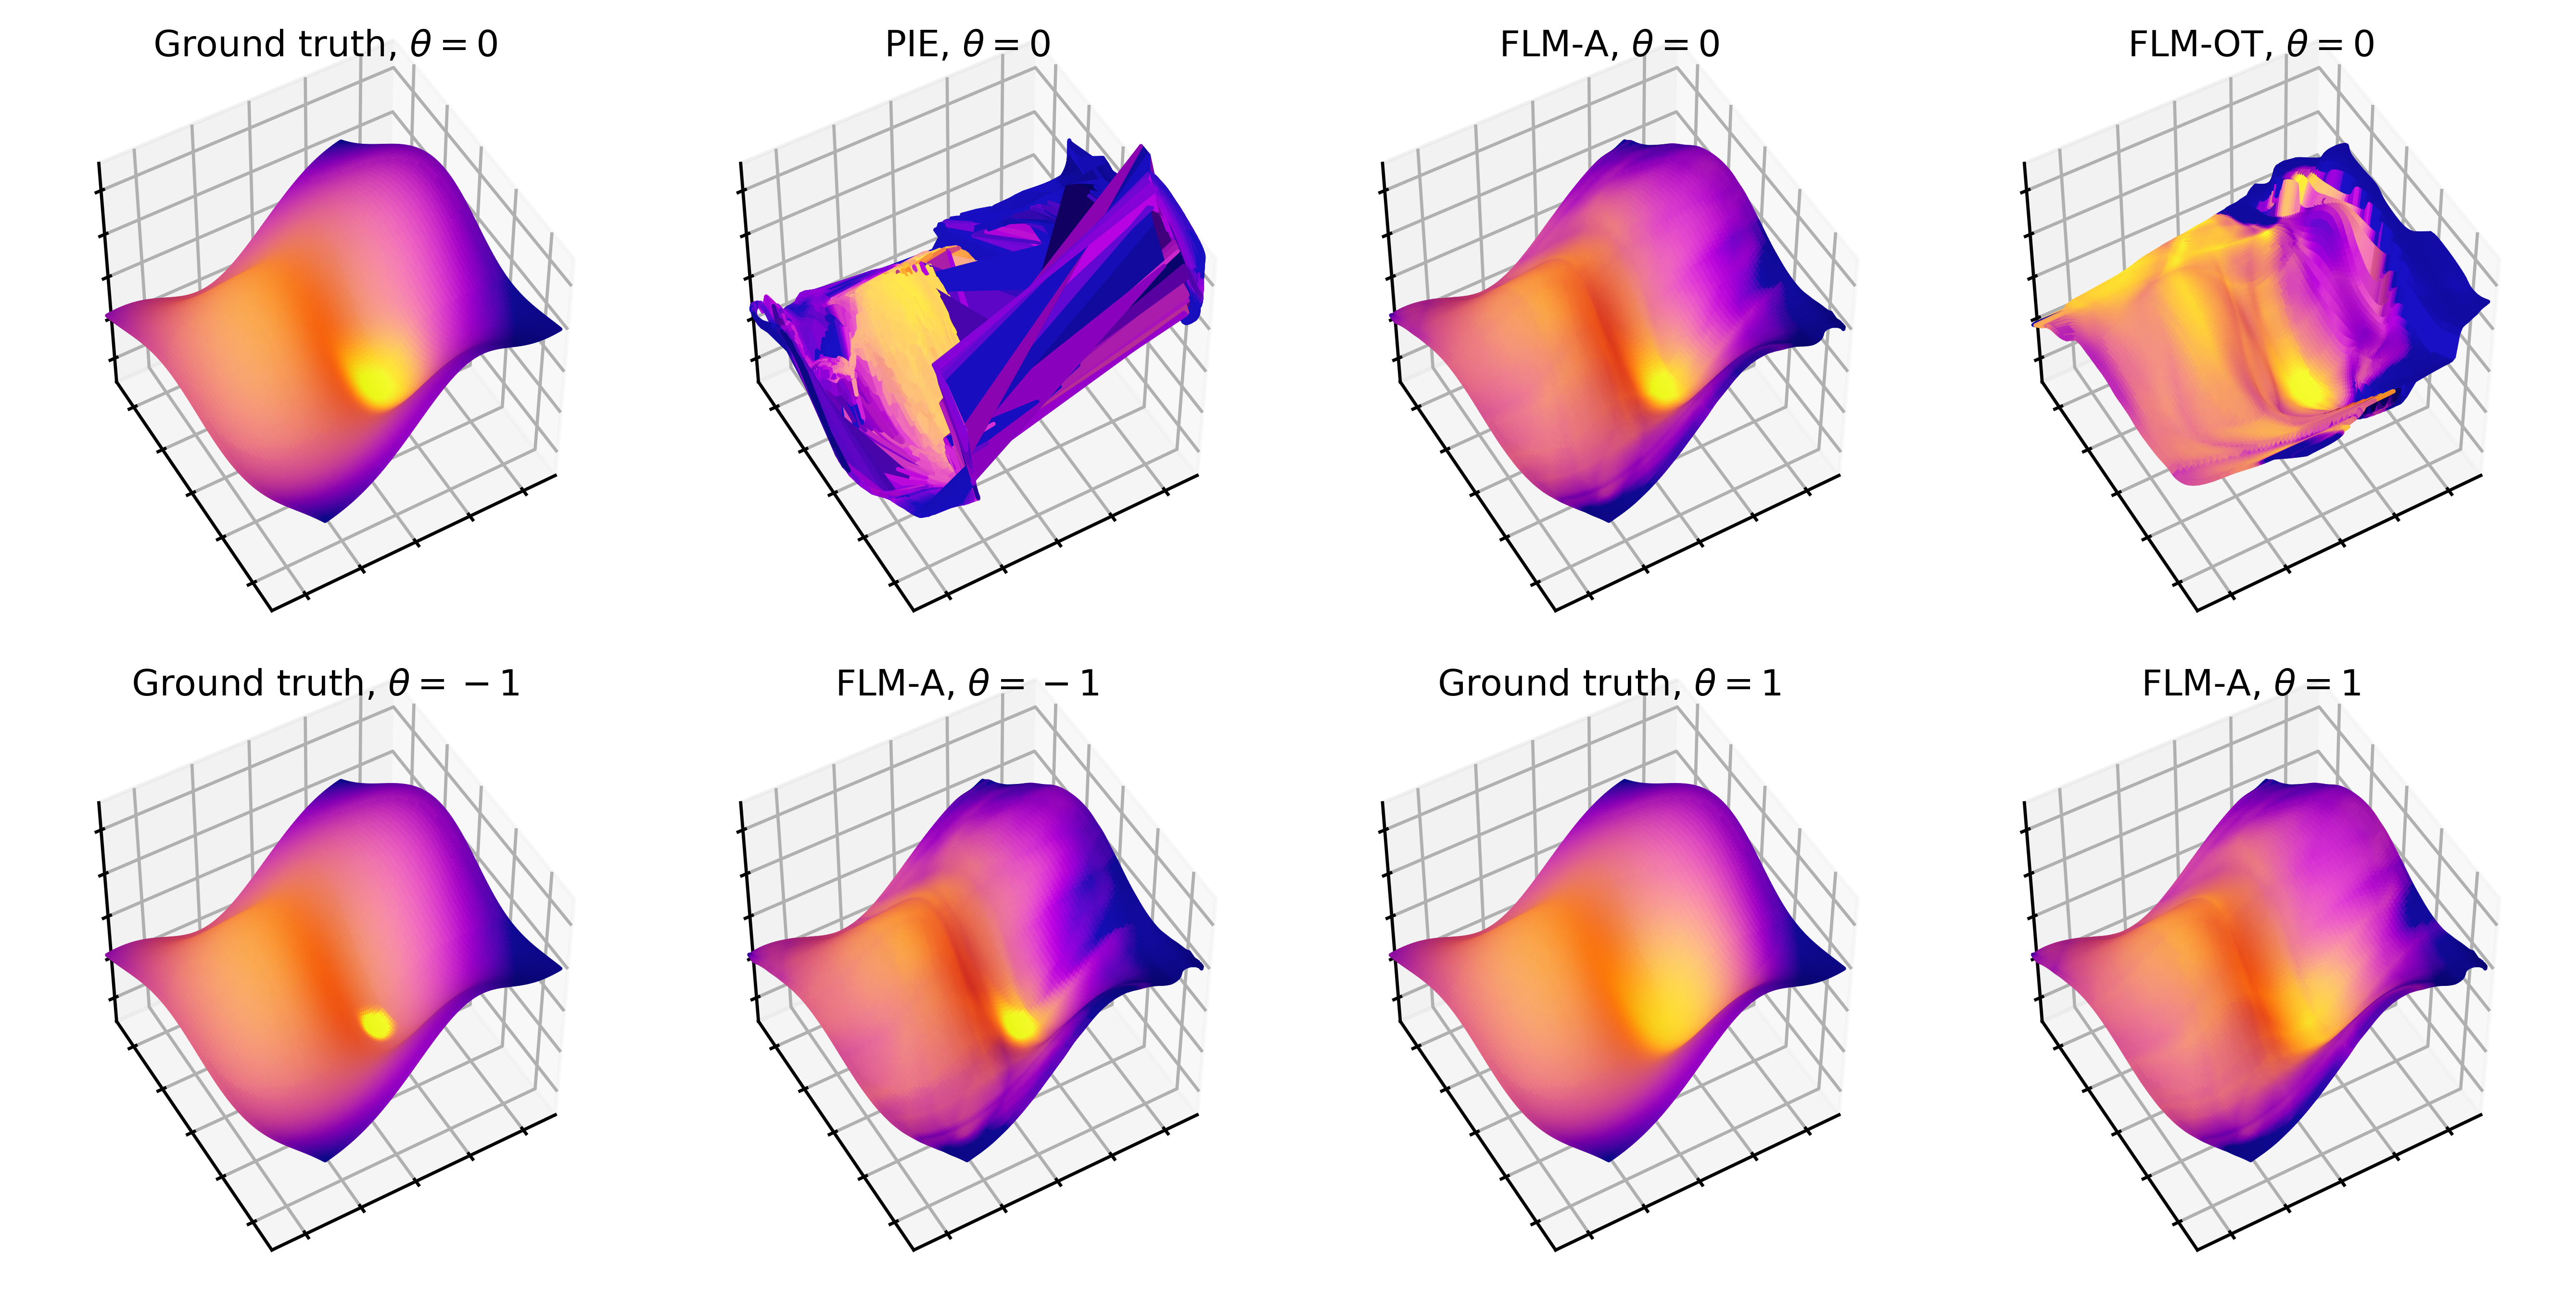

In [123]:
cmin, cmax = -10., -2.

def cmap(vals):
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


fig, gs = grid_width(4, 2, sep=0.03, lb_space=False)

for i, (x, logp, label) in enumerate(zip(xs, logps, labels)):
    ax = plt.subplot(gs[i], projection="3d")
    
    if i == 1:
        cmin, cmax = -8., 5.
    else:
        cmin, cmax = -10., -2.
        
    rgb = cmap(logp).reshape((res, res, 4))
    ls = LightSource(azdeg=90, altdeg=75)
    rgb_shaded = ls.shade_rgb(
        rgb[:,:,:3], elevation=x[:,2].reshape((res, res)), fraction=1.0, vert_exag=0.5, blend_mode="soft"
    )
    
    ax.plot_surface(
        x[:,0].reshape((res, res)),
        x[:,1].reshape((res, res)),
        x[:,2].reshape((res, res)),
        facecolors=rgb_shaded,
        rstride=1, cstride=1,
        linewidth=1.,
        shade=False
    )
#     ax.plot_wireframe(
#         x[:,0].reshape((res, res)),
#         x[:,1].reshape((res, res)),
#         x[:,2].reshape((res, res)),
#         rstride=10, cstride=10,
#         linewidth=0.5,
#         colors="0.8"
#     )

    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)

    ax.set_title(label, fontsize=9)
    ax.set_xticklabels([""]*3)
    ax.set_yticklabels([""]*3)
    ax.set_zticklabels([""]*3)
    
    ax.view_init(50, 60)

plt.savefig("../figures/power_manifold.pdf")


## Compare slice and correct density

In [124]:
xs = [
    mlfa_x_grid[1], mlfa_x_grid[1], mlfa_x_grid[1]
]
logps = [
    mlfa_pielogp_grid[0], mlfa_logp_grid[1], mlfa_pielogp_grid[0] - mlfa_logp_grid[1]
]
labels = [
    r"PIE density",
    r"FLM density",
    r"PIE density / FLM density",
]



In [125]:
m = np.mean(mlfa_pielogp_grid[0] - mlfa_logp_grid[1])
s = np.std(mlfa_pielogp_grid[0] - mlfa_logp_grid[1])

np.exp(m - 2*s), np.exp(m + 2*s)

(49.10158594251355, 2002.1490239720795)

In [126]:
m = np.mean(mlfa_logp_grid[0])
s = np.std(mlfa_logp_grid[0])

np.exp(m - 2*s), np.exp(m + 2*s)

(1.690879562087696e-05, 0.0951463743161422)

In [127]:
m = np.mean(mlfa_pielogp_grid[0])
s = np.std(mlfa_pielogp_grid[0])

np.exp(m - 2*s), np.exp(m + 2*s)

(0.009364484175390632, 28.458653229796003)

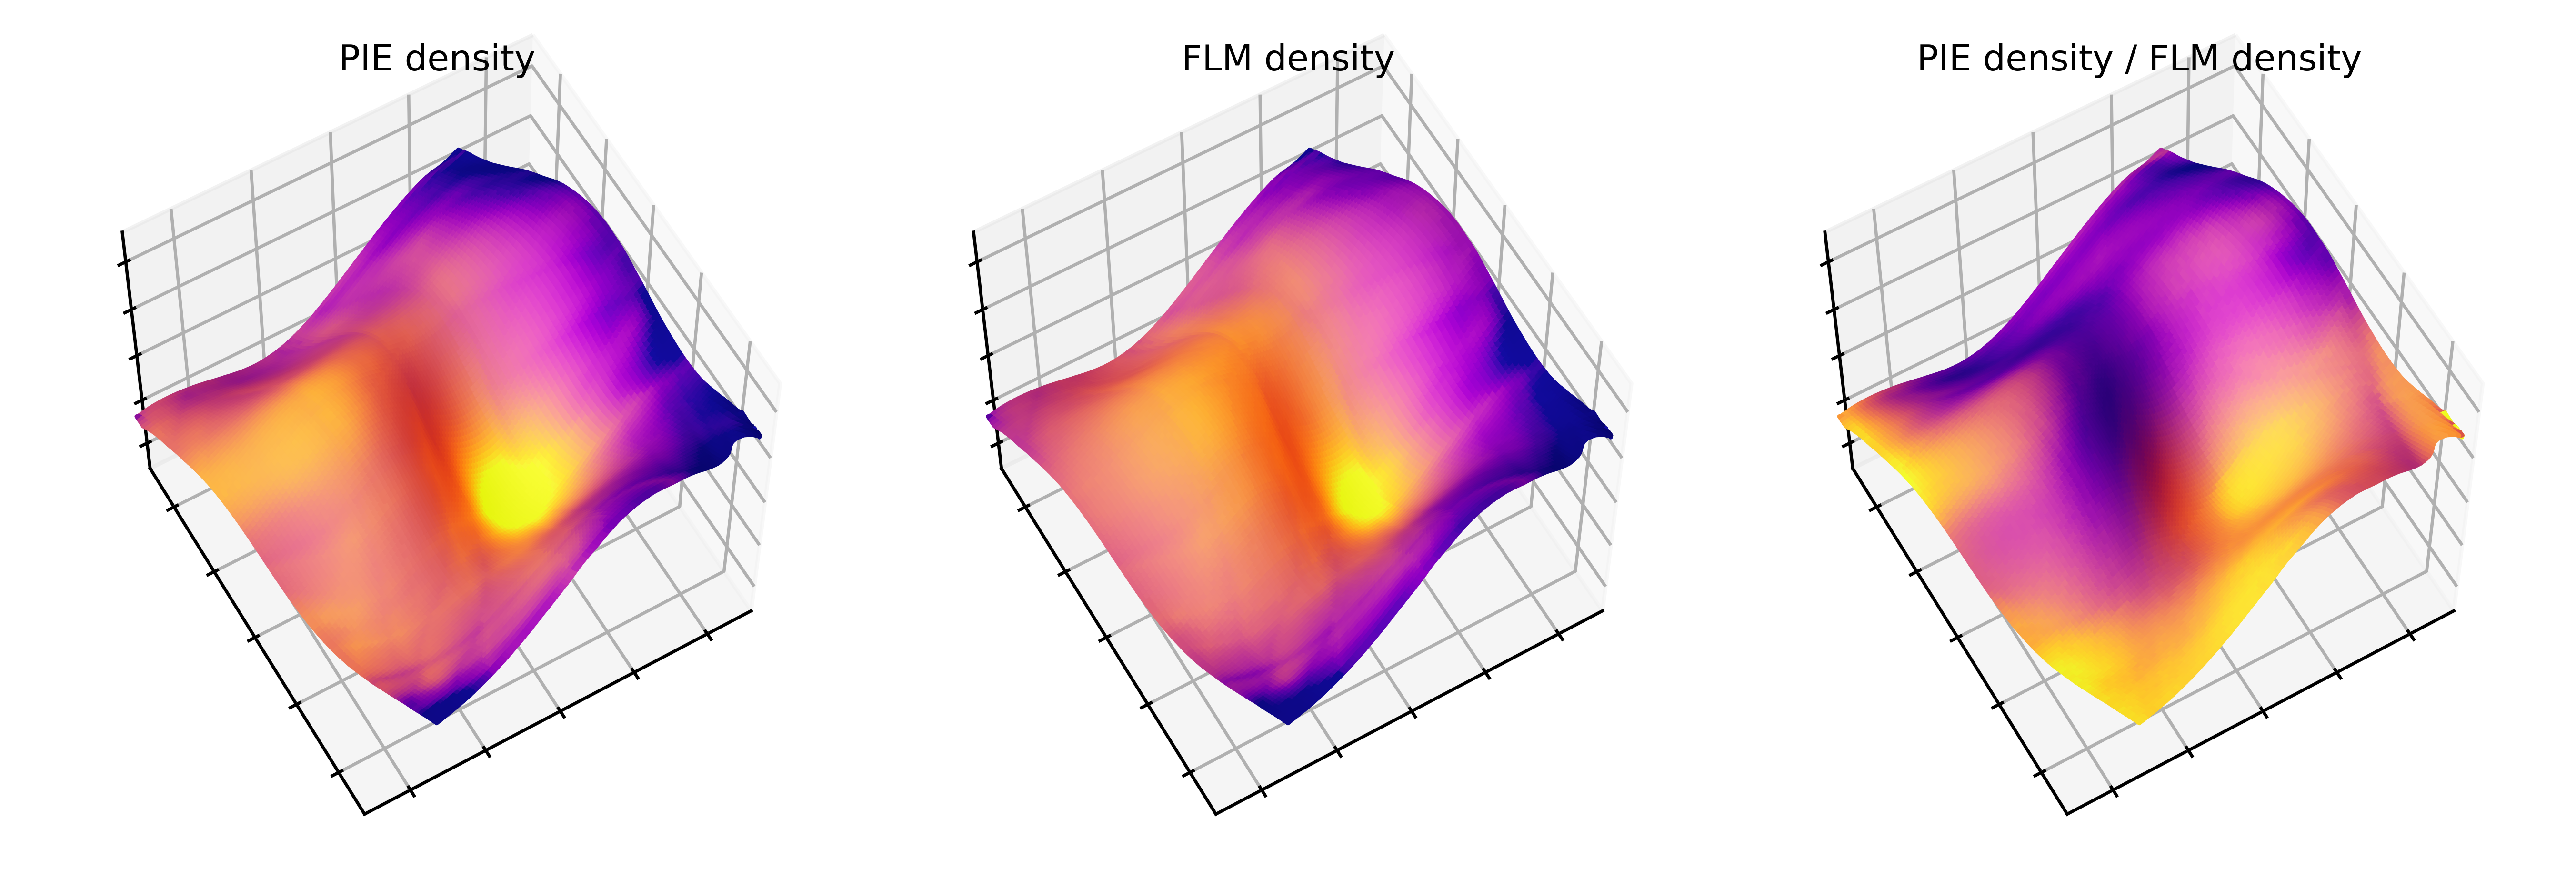

In [129]:
def cmap(vals):
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


fig, gs = grid_width(3, 1, sep=0.03, lb_space=False)

for i, (x, logp, label) in enumerate(zip(xs, logps, labels)):
    ax = plt.subplot(gs[i], projection="3d")
    
    cmin, cmax = np.mean(logp) - 2*np.std(logp), np.mean(logp) + 2*np.std(logp)
    
    rgb = cmap(logp).reshape((res, res, 4))
    ls = LightSource(azdeg=90, altdeg=75)
    rgb_shaded = ls.shade_rgb(
        rgb[:,:,:3], elevation=x[:,2].reshape((res, res)), fraction=1.0, vert_exag=0.5, blend_mode="soft"
    )
    
    ax.plot_surface(
        x[:,0].reshape((res, res)),
        x[:,1].reshape((res, res)),
        x[:,2].reshape((res, res)),
        facecolors=rgb_shaded,
        rstride=1, cstride = 1,
        linewidth=1.,
        shade=False
    )

    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)

    ax.set_title(label, fontsize=9)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
    # ax._axis3don = False
    ax.set_xticklabels([""]*3)
    ax.set_yticklabels([""]*3)
    ax.set_zticklabels([""]*3)
    
    ax.view_init(60, 60)

plt.savefig("../figures/power_manifold_pie_vs_mlf_density")



## Other (old) plots

In [ ]:
# cmin, cmax = -6., 6.

# fig = plt.figure(figsize=(10,4))

# ax = fig.add_subplot(1,2, 1)
# sc = ax.imshow(
#     f_grid.reshape((res, res)),
#     extent=(-boundary, boundary, -boundary, boundary),
#     cmap="RdYlBu",
#     vmin=cmin,
#     vmax=cmax,
#     origin="lower"
# )
# cbar = plt.colorbar(sc)
# ax.set_xlim(-boundary, boundary)
# ax.set_ylim(-boundary, boundary)

# ax = fig.add_subplot(1,2, 2)
# sc = ax.imshow(
#     logp_grid.reshape((res, res)),
#     extent=(-boundary, boundary, -boundary, boundary),
#     cmap="viridis",
#     vmin=np.max(logp_grid),
#     vmax=np.max(logp_grid)-10.,
#     origin="lower"
# )
# cbar = plt.colorbar(sc)
# ax.set_xlim(-boundary, boundary)
# ax.set_ylim(-boundary, boundary)

# plt.tight_layout()
# plt.show()


In [ ]:
# fig = plt.figure(figsize=(5,5))

# ax = fig.add_subplot(1,1,1, projection="3d")
# ax.plot_surface(
#     x_grid[:,0].reshape((res, res)),
#     x_grid[:,1].reshape((res, res)),
#     x_grid[:,2].reshape((res, res)),
#     color="orchid",
#     rstride=1, cstride = 1,
#     linewidth=1.
# )

# ax.set_xlim3d(-boundary, boundary)
# ax.set_ylim3d(-boundary, boundary)
# ax.set_zlim3d(-boundary, boundary)

# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")

# plt.tight_layout()
# plt.savefig("../figures/power_manifold.pdf")